# Supplementary Notebook for PhD Thesis:
## Title: *Direct and Indirect Energy Flexibility Interactions at the Building and Community Scale: From system to Human-Interfaced Systems


>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](../images/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2FNanaKofi%2Fpredis_indirect_flexibility/master?labpath=Indirect_flex_assessment.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.
    

In this notebook, we present a co-simulation approach that is composed of a Multi AGent Sysytem based simulation and a Mixed Integer linear Programming optimization for evaluating the human behaviour in an energy community.

Our use case involves the Predis-MHI builidng with the EV users being considered as an energy community that provides demand side energy flexibility services for the building.

For all intents and purposes, the diagram below represents the system being evaluated.

### Pictorial view of the building

![green-er.png](../images/green-er.png)

### The system setup
![fig18.png](../images/fig18.png)

## Data specifications
>### Predis-MHI
|#|Key |Description |
|---|---|---|
| 1 | name |Predis_data_2020_2022.csv | 
| 2 | title |Predis-MHI electricity consumption and production datatsets | 
| 3 | id | |
| 4 | description |dataset containing the demand profiles <br> (building and 4 charging stations) and the solar PV (22kWp) production profiles <br>  collected from the Building Management System of GreEn-ER |
| 5 | language | en-US |
| 6 | subject |Reference the topic of the resource in ontology terms  |
| 7 | keywords |Smart Building, <br>Living Lab,<br>Building energy data] |
| 8 | publicationDate | (2023-07-17) |
| 9 | context |Used in a study to assess the impact of <br> indirect flexiblty on the perfrmance of a building's energy system  |
| 10 | spatial | France  | 
| 11 | temporal |2020-01-01 to 2022-12-31  |
| 12 | source |G2ELab |
| 13 | licenses |CC By 4.0  |
| 14 | contributors |Nana Kofi Twum-Duah, Frederic Wurtz, Stéphane Ploix, Manar Amayri |
| 15 | resources |individual file  |
| 16 | resolution |1 hour | 



### Relevant imports

to run this notebook, the following libraries are required

* pandas Version => 1.2.4
* numpy Version => 1.19.5
* plotly Version => 4.14.1
* Pyomo Version ==  6.0.1
* mesa >= 0.8.9

### Note
This note book will not run if you do not install the dependancies, you can do that in the next cell <br>
``os.system('pip install -e .')`` in the next cell is not required if you have already done this in terminal<br>
if you need to install the dependancies, uncomment the entire code block


In [1]:
import os

work_path = os.getcwd()
########################################################
# #uncomment to install dependencies
# print (work_path)
# os.chdir("../")


# work_path = os.getcwd()

# print (work_path)

# os.system('pip install -e .')

# os.chdir(f"{work_path}\\notebooks")

# work_path = os.getcwd()

# print (work_path)
##################################################
# os.system('pip install ')
###Necessary for glpk to  work on binder (if not on binder comment out next line)
# os.system('conda install -c conda-forge glpk')

### NOTE

The ``show_plots`` parameter is to allow for the plots to bre rendered in the GitLab repository (GitLab does not render html plots). If you want an interactive notebook set it to ``False`` and rerun the entire notebook.



Alternatively, an HTML version of this notebook is provided in the folder **html_files**

In [12]:
show_plots = True

In [3]:
from tools.MAS_tools import optimizer,EV_agent, human_agents, charger_agent, data_collector, scheduler
from tools.MAS_tools.E_com import *
import pandas as pd
import plotly.express as px
import plotly.io as pio

import numpy as np

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [4]:
def copy_schedule(old,new,rng):

    for i in range(rng):
        # human agent
        new.schedule.agents[i][1].schedule = old.schedule.agents[i][1].schedule
        new.schedule.agents[i][1].projected_demand = old.schedule.agents[i][1].projected_demand

        # EV agent:
        new.schedule.agents[i][0].soc = old.schedule.agents[i][0].soc
        new.schedule.agents[i][0].avail_range = old.schedule.agents[i][0].avail_range
        new.schedule.agents[i][0].avail_bat = old.schedule.agents[i][0].avail_bat


    return new

        
        
def select_period(df,day):
    
    temp = df.copy()
    
    temp = temp.loc[str(day)]
    return temp

### Digital Twin Function

The digital twin is defined such that:

$$
        P_{\text{battery}_{DT}}(t) =  \begin{cases}\min [P_{\text {battery}_{MILP}}(t), P_{{PV}_{\text {measured}}}(t)], & \text{if  }  P_{\text {battery}_{MILP}}(t)>0 \\ 
        \max [P_{\text {battery}_{MILP}}(t),-P_{\text {load}_{\text {measured}}}(t)], & \text{if  }  P_{\text {battery}_{MILP}}(t) \leq 0\end{cases}
$$ 

Where $P_{\text{battery}_{DT}}(t)$, $P_{\text {battery}_{MILP}}(t)$, $P_{{PV}_{\text {measured}}}(t)$ and $P_{\text {load}_{\text {measured}}}(t)$ are the battery power from the digital twin, the battery power computed by the MILP, the measured solar PV power, and the measured demand of the building for timestep $t$ respectively. Additionally, to ensure the lower and upper state of charge limits were respected: 



$$
 P_{\text {battery} _{DT}}(t)= \begin{cases}E_{\text {battery} _{\max }}-E_{\text {battery }_{DT}}(t-1), & E_{\text {battery}_{DT}}(t)>E_{\text {battery}_{\max }} \\ E_{\text {battery}_{\min}}-E_{\text {battery}_{DT}}(t-1), & E_{\text {battery}_{DT}}(t) \leq E_{\text {battery}_{\min }}\end{cases}
$$ 

Where $E_{\text {battery}_{\min}}$ and $E_{\text {battery}_{\max}}$ are the minimum and maximum allowed energy in the battery (i.e. the minimum and maximum SOCs respectively and $E_{\text {battery }_{DT}}(t)$ is the energy in the battery at step $t$. 

In [5]:

def digital_twin(prod , demand, battery, bat_energy, c_eff, d_eff):
    
    energy = [bat_energy]
    new_bat = []
    
    for p,d,b in zip(prod , demand, battery):
        
        if b > 0:
            b = min(b,p)
            
            if energy[-1] + (c_eff * b ) <= 50:
                pass
                
            else:
                print("ERROR MAX SOC EXCEEDED")
                b = (50 - energy[-1])/c_eff
            
            energy.append(energy[-1] + (c_eff * b ))
            
            
            
        else:
            b = min(abs(b) , d)
            
            b *= -1
            
            if energy[-1] + (c_eff * b ) >= 10.5:
                pass
                
                
            else:
                print("ERROR MAX SOC EXCEEDED")
                
                b = (10.5 - energy[-1] ) * d_eff
            
            energy.append(energy[-1] + (b / d_eff))
        new_bat.append(b)
#     print (f"success : {new_bat}")
   
    end_cap = energy[-1]
        
    return end_cap,new_bat, energy[:-1]
        

In [6]:
opt = optimizer.Optimizer(capacity = 50, max_dis = -40, max_chg = 50,sd = 1e-6, ch_eff = 0.98,
                          min_soc = 10, dch_eff = 0.95,max_soc = 50)



## Load datasets

In [7]:
data = pd.read_csv ("../data/predis_data_2020_2022.csv",sep=",", decimal=".", header=0, encoding = "UTF-8")
data['Datetime']= pd.to_datetime(data['Datetime'],dayfirst = False)
data = data.set_index("Datetime")


data = data[data.index >= '2020-01-01 00:00:00']
data = data[data.index < '2023-01-01 00:00:00']

## Co-Simulation approach:

### The MAS Approach
The Multi Agent System based simulation followed the sequance depicted below:
![fig51a.png](../images/fig51a.png)
We devised two approaches based on how the optimal startegy was computed and how the human agents were signaled:


#### The Generalized approach
For this approach, there are two components; the optimization component and the simulation component. The optimization component is realized using a MILP optimizer whilst the simulation component is achieved using MAS. 


The optimization entails using the predicted PV production, demand, and the EV charger demand (this comes from the EV agents) to optimize the use of the 50-kwh stationary battery and the plugging and unplugging of EVs. Thus, for this approach, the availability of human agents is not required for determining the optimal scheduling of the battery (i.e., the direct flexibility) and the scheduling of EV charging. The optimal strategy is calculated at the start of each simulation day and the signaling is then subsequently sent to the human agents on an hourly basis. 


Based on the optimal schedule obtained from the MILP, the corresponding signals (one signal per timestep) are then sent to each human agent. Each human agent receives the same signal and decides to charge or not charge based on the received signal, the State of Charge (SOC) of their EV, and their willingness to participate. If the decision is to charge, then the human agent checks for an available charging point and proceeds to use one if there are any such charging points unoccupied.


![fig49.png](../images/fig49.png)

#### The Indvidualized approach
Similar to the Generalized approach, this approach also considers two components, the optimization and simulation components. In this approach, however, the schedule of the human actor is a key component for the optimal scheduling of the battery and chargers. Thus, the day ahead schedule (i.e., the availability) of the human agent must be known and transmitted to the coordinator agent at the beginning of the day simulation. 

![fig50.png](../images/fig50.png)

Based on this schedule, the \acrshort{MILP} optimizer proposes an optimal EV charging schedule that is adapted to the additional constraint induced by the availability of human agents. Thus, for this approach, each timestep has n number of signals, where n is the number of human agents (specifically EV owners). 

The problem formulation for the individualized approach builds on the \acrshort{MILP} formulation considered in the generalized approach. Thus, for this optimization, we consider the schedules of the human agents, the objective function was defined such that:  

$$
\text { objective }=\min \sum_t E_{\text {unmet }}+\left[P_{\text {import }}(t)-P_{\text {export }}(t)\right] \times \text { timestep }
$$

Where $\left[P_{\text {import }}(t)-P_{\text {export }}(t)\right] \times timestep$ refers to the Net Energy Exchanged with the Grid (NEEG) and $E_{unmet}$ is the total unsatisfied energy demand of the EV charging stations and is expressed mathematically as: 

$$
E_{\text {unmet }}=\sum_{x=1}^{X} E_{\text {demand EVs }}(x)-\sum_{t=0}^T \sum_{\text {ch=1 }}^{CH} P_{\text {charger}}(\text { ch, } t) \times \text { timestep }
$$    

Where $\sum_{x=1}^{X} E_{\text {demand EVs }}(x)$ is the total demand of the EVs and $x$ is a member of the set of EVs defined as $\{1,2,…, X \}$ and $P_{\text {charger}}(ch,t) \times timestep$ is the energy consumed by the charger denoted by $ch$ ($ch$ is a member of the set$\{1,2,.., CH\}$) at timestep $t$. 

To determine the time for each EV user to plug in and unplug their vehicle (i.e., the personalized optimal charging schedule), the constraints below were employed:

$$
        T_{\text {unplug }}(x, ch, t)=T_{\text {plug in }}(x,  ch, t)=\left\{\begin{array}{l}
        0, \quad \text { if } E V_{\text {avail }}(x, t)=0 \\
        0, \quad \text { if hour }<T_{\text {open }} \text { or hour }>T_{\text {close }}
        \end{array}\right.
$$
Else,

$$
    \sum_{ch=1}^{CH} T_{\text {plug in}}(x, c h, t) \leq 1 
$$

$$
    \sum_{ch=1}^{C H} T_{\text {unplug }}(x, c h, t) \leq 1
$$

Where $T_{\text {plug in}}(x, c h, t)$ and $T_{\text {unplug }}(x, c h, t)$ are binary values for determining the time to signal a plug in or unplug event for EV designated as $x$ at the charger $ch$, and $E V_{\text {avail }}(x, t)$ refers to the schedule of EV $x$. Having defined a constraint that ensures that the EV owner plugs in and unplugs their EV, it is essential to ensure that a plug-in event is a precursor to an unplug event, thus, the following constraint was introduced into the problem definition: 

$$
        \sum_{ch}^{CH} \sum_t^T T_{\text {unplug }}(x, ch, t) \times t-\sum_{ch}^{CH} \sum_t^T T_{\text {plug in }}(x, c h, t) \times t\left\{\begin{array}{l}
        =0, \text { if } \sum_t E V_{\text {avail }}(x, t) \leq 1 \\
        \geq 1, \text { if } \sum_t E V_{\text {avail }}(x, t)>1
        \end{array}\right.
$$

This ensures that for an EV to be considered for charging there is more than 1 hour of availability and that $T_{unplug}$ is always greater than $T_{plug in}$. Furthermore, to prevent an EV owner from being assigned a charge event multiple times during the optimization horizon (1 day) and also to ensure multiple EVs are not assigned to the same charger: 

$$
    \sum_{c h}^{C H} \sum_t^T T_{\text {plug in }}(x, c h, t) \leq 1
$$
And to ensure that an EV owner receives the same number of plug-in requests as unplug requests: 

$$
    \sum_t^T T_{\text {plug in }}(x, c h, t)=\sum_t^T T_{\text {unplug }}(x, c h, t)
$$

Given that the availability of EV reduces the feasible region of our optimization, the hard constraint defined in eqn \ref{eqn3.8} had to be relaxed such that: 

$$
\sum_{t=0}^T \sum_{\text {ch=1 }}^{C H} P_{\text {charger }}\text { (ch,t) } \times \text { timestep } \leq \sum_{x=1}^X E_{\text {demand } E V s}(x).
$$

Lastly, to prevent an EV user from being assigned to multiple chargers, we added the constraint: 

$$
\sum_o T_{p l u g \text { in }}(x, c h, t) \leq 1
$$





## The Co-simulation Approach

The image below shows a summarized version of the proposed co-simulation approach

![fig51.png](../images/fig51.png)

* **Step 1 - Initialization step**: in this step, the MAS is initialized and provides as an output the starting state of charge $SOC(0)$ for each EV in the simulation. Considering the starting SOC and the daily distance to be traveled, the projected demand for each EV (and by extension the accompanying human agent) is estimated. Furthermore, at this stage, each human agent generates their availability (1 for available and 0 for busy) for the simulation horizon (24 hours in our use case). 

* **Step 2 - Optimization Step: In this step, the projected demand and the availability of the human agents (only for the individualized approach), the current state of the battery \sidenote[][-2.0cm]{The battery state of charge at initialization is considered to be the last state of charge for the previous day ($SOC(23)$) and is an output from the battery's digital twin (described in chapter \ref{ch:4_Case_stdy}, except in the first run of the simulation where it is a user input} are provided as inputs to the \acrshort{MILP} optimizer. At the output, the optimizer provides the optimal charging schedule for the EVs (personalized in the individualized approach) and the optimal battery schedule. 

* **Step 3 - Simulation Step: This step is in two phases: the first step involves the simulation of the MAS to provide the charging profiles (from the Charger Agents) as depicted in \reffig{fig51a}. In this phase, behavior associated with the use of charging infrastructure is simulated. 


After These 3 steps, the second phase involves the simulation of the battery (using the digital twin, thus, the digital twin takes as input the EV demand (from MAS) the building demand, and the solar PV production. The outputs of the digital twin in this phase are the end-of-day SOC ($SOC(23)$) and the simulated battery schedule. 

In [8]:
def simulation(agent_info = {} , data = None, sim_no:int = 50 ,start_day:int = 120, end_day: int = 150, init_cap = 15):
    dates = [d.date() for d in data.resample("1D").asfreq().index]
    
    pd_ind,pd_gen,dm_ind,dm_gen =[],[],[],[]
    demand_info = pd.DataFrame({'projected_demand_ind'  : [[0] * (end_day - start_day)]*sim_no ,
                      "demand_met_ind_MILP" : [[0] * (end_day - start_day)]*sim_no ,
                      "demand_met_ind_MAS" : [[0] * (end_day - start_day)]*sim_no ,
                      'projected_demand_gen' : [[0] * (end_day - start_day)]*sim_no ,
                       "demand_met_gen_MILP" : [[0] * (end_day - start_day)]*sim_no ,
                      "demand_met_gen_MAS" : [[0] * (end_day - start_day)]*sim_no,
                     })

    results_ind , results_gen = {}, {}
    horizon = 24

    for i in range (sim_no):

        r_ind, r_gen  = pd.DataFrame(), pd.DataFrame()

        init_cap = init_cap
        init_ind, init_gen = init_cap , init_cap 
        
        
        t = {'projected_demand_ind'  :[],
                      "demand_met_ind_MILP" : [] ,
                      "demand_met_ind_MAS" : [],
                      'projected_demand_gen' : [] ,
                       "demand_met_gen_MILP" : [],
                      "demand_met_gen_MAS" : [] ,
                     }


        for day in dates[start_day:end_day]:
            sim_data = select_period(df=data.copy() , day = day)

        #     create model of the energy community 
            ec_model_ind = EnergyCommunity(agent_info)
            ec_model_gen = ec_model_ind.create_copy()
            
            
            
            
            owners = [i + 1 for i in range(len(ec_model_ind.proj_demand))]


            ###################################################################################
            ##                              INDIVIDUAL APPROACH                              ##
            ###################################################################################
            
            print (init_ind)
            try:
                ec_model_ind.nudges, temp_ind , end_cap, m = opt.opt_individual(demand = ec_model_ind.proj_demand, 
                                                                             prod=sim_data.production.copy(), 
                                                                                load=sim_data.Consumption.copy(),
                                                                             init_cap=init_ind, datess=sim_data.index, 
                                                                             owners=owners, ev_avail=ec_model_ind.schedule_list,  
                                                                             verbose=True)
            except:
                
                print ("#######################ERROR####################")
                print (sim_data)
                sim_data.fillna(0, inplace = True)
                ec_model_ind.nudges, temp_ind , end_cap, m = opt.opt_individual(demand = ec_model_ind.proj_demand, 
                                                                             prod=sim_data.production.copy(), 
                                                                                load=sim_data.Consumption.copy(),
                                                                             init_cap=init_ind, datess=sim_data.index, 
                                                                             owners=owners, ev_avail=ec_model_ind.schedule_list,  
                                                                             verbose=True)


            while  m.end_cap.value == None:


                clear_output(wait=True)
                print("Optimization failed")

                sleep (50)
                ec_model_ind = EnergyCommunity(agent_info)
                ec_model_gen = ec_model_ind.create_copy()

                ec_model_ind.nudges, temp_ind , end_cap, m = opt.opt_individual(demand = ec_model_ind.proj_demand, 
                                                                         prod=sim_data.production, load=sim_data.Consumption,
                                                                         init_cap=init_ind, datess=sim_data.index, 
                                                                         owners=owners, ev_avail=ec_model_ind.schedule_list,  
                                                                         verbose=True)


        
            

            temp_ind.set_index("dates", inplace = True)
            temp_ind["demand_MILP"] = temp_ind.load + temp_ind[[f"chargers_{x}" for x in range (1,5)]].sum(axis = 1)
            
            
            dm_ind.append(temp_ind[[f"chargers_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0))
            
            t["demand_met_ind_MILP"].append(temp_ind[[f"chargers_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0))
#             d.loc[i,"demand_met_ind_MILP"] = temp[[f"chargers_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0)
            
            c = [f"chargers_{x}" for x in range(1,5)]
            temp_ind = temp_ind[['grid_import', 'grid_export','battery_power','battery_energy', 'production', 'load','demand_MILP'] + c]

            for hour in range (horizon):
                ec_model_ind.step(current_date= temp_ind.index[hour], nudges = ec_model_ind.nudges , sim_type = "advanced")

            temp_df = ec_model_ind.container.get_collector_data()

            for x in range (1,5): 
                temp_ind[f"charger_mas_{x}"] = temp_df[f"charger_{x}_power"].tolist()


            temp_ind["demand_mas"] = temp_ind.load + temp_ind[[f"charger_mas_{x}" for x in range (1,5)]].sum(axis = 1)

            end_cap,new_bat,en = digital_twin(prod = temp_ind["production"].tolist() ,
                                       demand = temp_ind["demand_mas"].tolist(),
                                       battery = temp_ind["battery_power"],
                                        bat_energy= init_ind,
                                        c_eff = 0.98,
                                        d_eff = 0.95)

            temp_ind["battery_power_DT"] = new_bat
            
            r_ind = pd.concat([r_ind, temp_ind])

            init_ind = end_cap
            
            pd_ind.append(sum(ec_model_ind.proj_demand))
            
            
            t["projected_demand_ind"].append(sum(ec_model_ind.proj_demand))
            t["projected_demand_gen"].append(sum(ec_model_gen.proj_demand))
            
            
            t["demand_met_ind_MAS"].append(temp_df[[f"charger_{x}_power" for x in range(1,5)]].sum(axis=1).sum(axis=0))
            clear_output(wait=True)

            ####################################################################################
            ##                              GENERAL APPROACH                                  ##
            ####################################################################################

            end_cap , m, temp_gen, ec_model_gen.nudges =  opt.opt_general(demand = ec_model_gen.proj_demand, 
                                                                       prod=sim_data.production, owners= owners, 
                                                  load=sim_data.Consumption,
                                                init_cap=init_gen,datess = sim_data.index)

            print(ec_model_gen.nudges)

            temp_gen.set_index("dates", inplace = True)
            
            dm_gen.append(temp_gen[[f"charger_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0))
            temp_gen["demand_MILP"] = temp_gen.load + temp_gen[[f"charger_{x}" for x in range (1,5)]].sum(axis = 1)
            
            
            c = [f"charger_{x}" for x in range(1,5)]
            t["demand_met_gen_MILP"].append(temp_gen[[f"charger_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0))
            
            
            
#             d.loc[i,"demand_met_gen_MILP"] = temp[[f"charger_{x}" for x in range(1,5)]].sum(axis=1).sum(axis=0)
            temp_gen = temp_gen[['grid_import', 'grid_export','battery_power', "battery_energy",'production', 'load',"demand_MILP"] +c ]

            for hour in range (horizon):
                ec_model_gen.step(current_date= temp_gen.index[hour], nudges = ec_model_gen.nudges , sim_type = "advanced")

            temp_df = ec_model_gen.container.get_collector_data()

            for x in range (1,5): 
                temp_gen[f"charger_mas_{x}"] = temp_df[f"charger_{x}_power"].tolist()

            temp_gen["demand_mas"] = temp_gen.load + temp_gen[[f"charger_mas_{x}" for x in range (1,5)]].sum(axis = 1)

            end_cap,new_bat,en = digital_twin(prod = temp_gen["production"].tolist() ,
                                       demand = temp_gen["demand_mas"].tolist(),
                                       battery = temp_gen["battery_power"],
                                        bat_energy= init_gen,
                                        c_eff = 0.98,
                                        d_eff = 0.95)

            temp_gen["battery_power_DT"] = new_bat
            
            t["demand_met_gen_MAS"].append(temp_df[[f"charger_{x}_power" for x in range(1,5)]].sum(axis=1).sum(axis=0))
            
#             
            
            pd_gen.append(sum(ec_model_gen.proj_demand))
            
            
            
            r_gen = pd.concat([r_gen, temp_gen])
            init_gen = end_cap
            clear_output(wait=True)
        
        
        demand_info.loc[i,"projected_demand_ind"] = t["projected_demand_ind"]
        demand_info.loc[i,"demand_met_ind_MILP"] = t ["demand_met_ind_MILP"]        
        demand_info.loc[i,"demand_met_ind_MAS"] =  t["demand_met_ind_MAS"]
        
        demand_info.loc[i,"projected_demand_gen"] = t["projected_demand_gen"]
        demand_info.loc[i,"demand_met_gen_MILP"] = t["demand_met_gen_MILP"]
        demand_info.loc[i,'demand_met_gen_MAS'] = t["demand_met_gen_MAS"]
            

        r_ind["Self_cons_MILP"]  =  np.minimum(r_ind["production"] - r_ind["battery_power"], r_ind[f"demand_MILP"])
        r_ind["Self_cons_DT"]  =  np.minimum(r_ind["production"] - r_ind["battery_power_DT"], r_ind[f"demand_mas"])
        results_ind[f"RUN:{i+1}"] = r_ind

        r_gen["Self_cons_MILP"]  =  np.minimum(r_gen["production"] - r_gen["battery_power"], r_gen[f"demand_MILP"])
        r_gen["Self_cons_nat"]  =  np.minimum(r_gen["production"], r_gen[f"load"])
        r_gen["Self_cons_DT"]  =  np.minimum(r_gen["production"] - r_gen["battery_power_DT"], r_gen[f"demand_mas"])
        results_gen[f"RUN:{i+1}"] = r_gen
        
        
        r_gen = r_ind = 0

        clear_output(wait=True)
        
    
    
    ####################################################################################
    ##                              GENERAL APPROACH EVALUATION                       ##
    ####################################################################################

    nsc , sc_milp, sc_dt = [],[],[]

    for key in results_gen.keys():
        temp = results_gen[key]

        sc_milp.append(temp["Self_cons_MILP"].sum() / temp["production"].sum())
        sc_dt.append(temp["Self_cons_DT"].sum() / temp["production"].sum())
        nsc.append(temp["Self_cons_nat"].sum() / temp["production"].sum())

    df_temp = pd.DataFrame({"General_MILP" :sc_milp , "General_DT" : sc_dt ,"Natural" : nsc} ,
                           index = [i for i in range (1,sim_no + 1)] )


    ####################################################################################
    ##                           INDIVIDUAL APPROACH EVALUATION                       ##
    ####################################################################################

    sc_milp, sc_dt = [],[]

    for key in results_ind.keys():
        temp = results_ind[key]

        sc_milp.append(temp["Self_cons_MILP"].sum() / temp["production"].sum())
        sc_dt.append(temp["Self_cons_DT"].sum() / temp["production"].sum())
    

    df_temp["Individual_MILP"]   = sc_milp
    df_temp["Individual_DT"]   = sc_dt
    
    abc = pd.DataFrame({"pd_ind": pd_ind,"pd_gen":pd_gen, "dm_ind" : dm_ind,"dm_gen" : dm_gen})
    
    return {"results_general" : results_gen , "results_individual": results_ind , "selfcons"  : df_temp , "demand_info": demand_info,
           "abc" : abc}
    print("SUCCESS")

### Begin simulation
We consider a huan agent to have a willingness to particpate parameter, this parameter represents a liklihood to follow the community recommendations. Thus a  willingess of 1 represents a very motivated human agent and a willingness of Zero represents an apathetic human. in this regard a willingness of 0.5 thus, represents a neutral human  agent 


Follwong this definition, four simulations were carried out:

* **Motivated Human Agents Scenario**  
* **Apathetic Human Agents Scenario**
* **Neutral Human Agents Scenario**
* **Hybrid Human Agents Scenario**


In [9]:
 %%time

# Each human agent created with a corresponding EV
willingness = {"good" : [1,1,1] , "bad" : [0,0,0] , "mix": [1,0,0.5], "neutral": [0.5,0.5,0.5]}

# set number of repeated simulations
sim_no = 50

all_results = {}
start_day, end_day = 731, -1
for key in willingness:
    will = willingness[key]

    agent_info = [[{ "name": "Tesla_Model_S_1" ,"max_range": 350,"batt_cap" : 52,"min_soc" : 0.4, 'km_p_kwh' : 5.2 } ,
                   {"agent_name": "S_1" , "time_to_work":9, "time_to_home":17, "daily_dist":25 , "type" : will[0]}],

                   [{ "name": "Tesla_Model_S_2" ,"max_range": 350,"batt_cap" : 52,"min_soc" : 0.35, 'km_p_kwh' : 5.2 } ,
                   {"agent_name": "S_2" , "time_to_work":8, "time_to_home":18, "daily_dist":12, "type" : will[0]}],

                  [{"name": "Tesla_Model_S_3", "max_range": 350, "batt_cap": 52, "min_soc": 0.35, 'km_p_kwh': 5.2},
                   {"agent_name": "S_3", "time_to_work": 8, "time_to_home": 18, "daily_dist": 20, "type" : will[1]}],

                  [{ "name": "Tesla_Model_S_4" ,"max_range": 350,"batt_cap" : 52,"min_soc" : 0.35, 'km_p_kwh' : 5.2 } ,
                   {"agent_name": "S_4" , "time_to_work":8, "time_to_home":18, "daily_dist":60, "type" : will[1]}],

                  [{"name": "Tesla_Model_S_5", "max_range": 350, "batt_cap": 52, "min_soc": 0.35, 'km_p_kwh': 5.2},
                   {"agent_name": "S_5", "time_to_work": 8, "time_to_home": 18, "daily_dist": 28, "type" : will[2]}],

                    [{ "name": "Tesla_Model_S_6" ,"max_range": 350,"batt_cap" : 52,"min_soc" : 0.35, 'km_p_kwh' : 5.2 } ,
                   {"agent_name": "S_6" , "time_to_work":8, "time_to_home":18, "daily_dist":29, "type" : will[2]}],

    #               [{"name": "Tesla_Model_S_7", "max_range": 350, "batt_cap": 52, "min_soc": 0.35, 'km_p_kwh': 5.2},
    #                {"agent_name": "S_7", "time_to_work": 8, "time_to_home": 18, "daily_dist": 38, "type" : will[0]}],


                  ]
    all_results[key] = simulation(agent_info = agent_info , data = data.copy(), sim_no = sim_no ,init_cap = 25,
                                  start_day = start_day, end_day = end_day)
    

    

CPU times: total: 15h 34min
Wall time: 21h 12min 15s


In [10]:
ac_after = {}
for key in all_results.keys():
    
    sc_mas_gen ,sc_mas_ind= [],[]
    for i in range (1,sim_no+1):
        temp = all_results[key]["results_general"][f"RUN:{i}"].copy()
        temp["sc"] = np.minimum(temp["production"] , temp[f"demand_mas"] )
        sc_mas_gen.append((temp["sc"].sum() / temp["production"].sum()) *100)
        
        
        
        temp = all_results[key]["results_individual"][f"RUN:{i}"].copy()
        temp["sc"] = np.minimum(temp["production"] , temp[f"demand_mas"] )
        sc_mas_ind.append((temp["sc"].sum() / temp["production"].sum()) *100)
    ac_after[f"{key}_IND"] = sc_mas_ind
    ac_after[f"{key}_GEN"] = sc_mas_gen



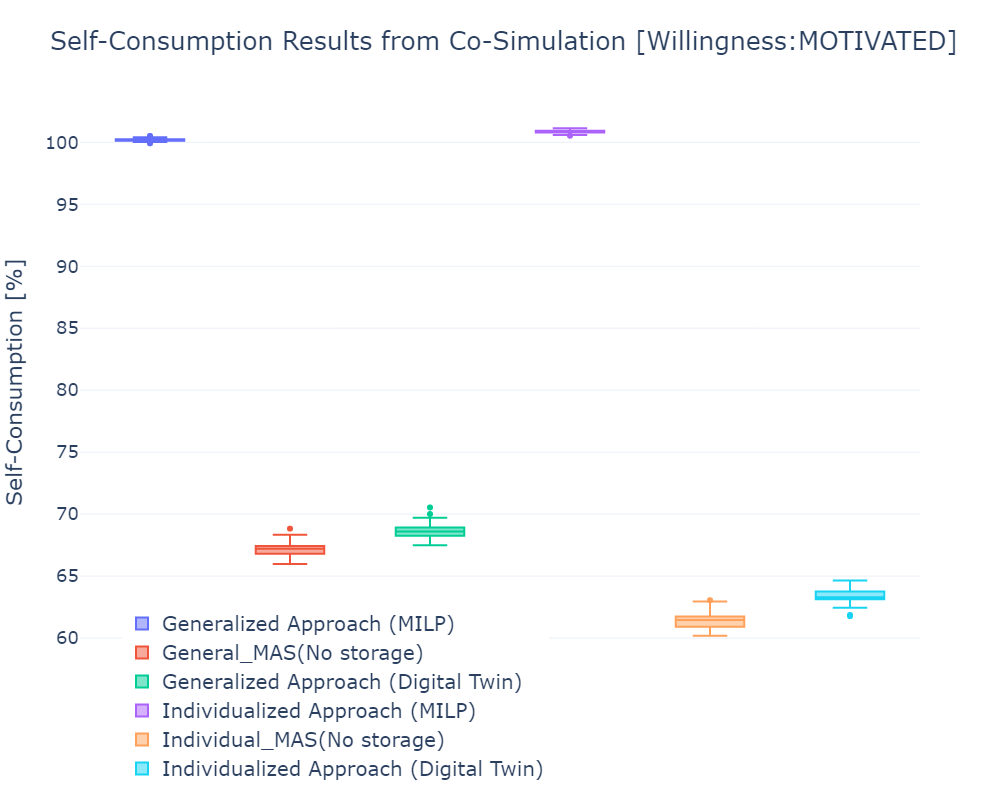

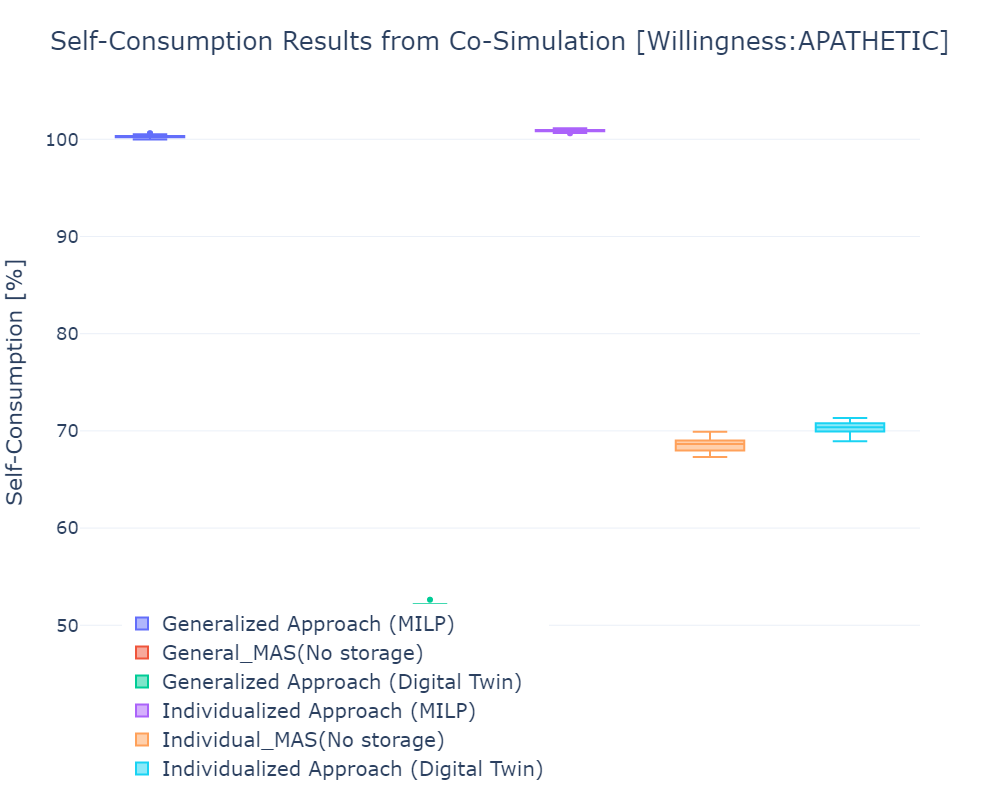

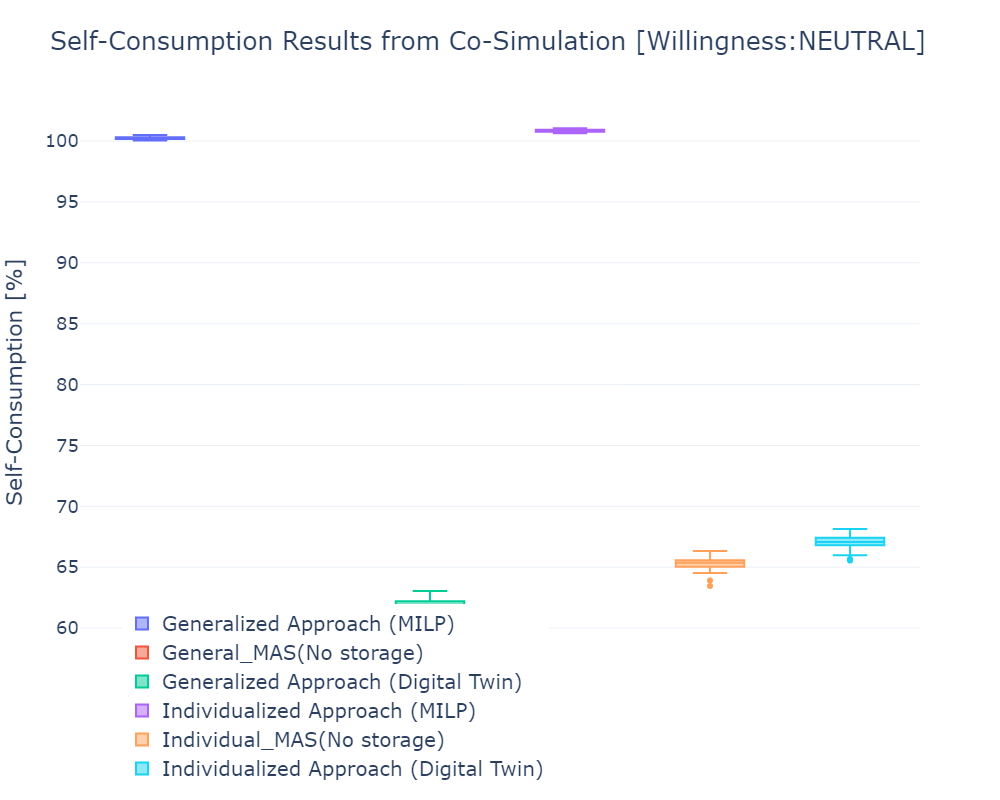

In [13]:
import plotly.subplots as sp

w ,h=1100, 800
layout = {
    "height" : h,"width" : w,
   "font":{"size" : 18}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45, "showticklabels" : False},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',"title_text":"Self-Consumption [%]"},
    "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.22,"x":0.050, "title" : ""}
            }
            
color = ["blue","green","orange","magenta","cyan"]

translate  = {"good" : "MOTIVATED" , "bad":"APATHETIC", "neutral": "NEUTRAL", "mix" : "HYBRID"}

fn = 52
for key in all_results.keys():
    subfig = sp.make_subplots(specs=[[{"secondary_y": False}]])
    
    temp = all_results[key]["selfcons"].copy() * 100
    temp.rename(columns = {"Natural" :"Natural Self-consumption", 
                           "General_MILP":"Generalized Approach (MILP)",
                           "General_DT" : "Generalized Approach (Digital Twin)",
                           "Individual_MILP" : "Individualized Approach (MILP)" ,
                           "Individual_DT":"Individualized Approach (Digital Twin)"}, inplace =True)
    i = 0
    temp = temp[["Natural Self-consumption","Generalized Approach (MILP)","Generalized Approach (Digital Twin)",
                "Individualized Approach (MILP)","Individualized Approach (Digital Twin)"]]
#     print (temp)
    for column in temp.columns: 
        
        if "Natural" in column:
#             fig = px.bar(temp[[column]].loc[2] * 100,color_discrete_sequence = ["red"],)
            pass
            
        else:
#             fig.add_box(y=data['Values'][i], name=group)
            
            
            subfig.add_box(y = temp[column].tolist(),name = column, row=1, col=1)
            if "Generalized Approach (MILP)" in column:
                subfig.add_box(y = ac_after[f"{key}_GEN"],name = "General_MAS(No storage)", row=1, col=1)
            elif "Individualized Approach (MILP)" in column:
                subfig.add_box(y = ac_after[f"{key}_IND"],name = "Individual_MAS(No storage)", row=1, col=1)
            i += 1
    
#         subfig.add_traces(fig.data )
    
    subfig.update_layout(layout, title= f"Self-Consumption Results from Co-Simulation [Willingness:{translate[key]}]")
    if show_plots:

        subfig.show("png",width = 1000)

    else:
        subfig.show()

    fn += 1
    



### Comment

* The results show that optimization strategies were able to achieve high self-consumption rates (greater than 100\% because of the energy in the battery at initialization).

* However, in this scenario, the Generalized approach proved more effective
* Also of interest is the self-consumption rate only using the indirect flexibility (This parameter is denoted by General_MAS (no storage) for the generalized approach and Individual_MAS (no storage)). 


* Given that the scenrio with only motivated agents is an ideal (best) case, and the optimal cases did not vary significantly between the individualized and generalized approaches, one would expect the individualized approach to have performed better. However, since in this approach, each agent receives a maximum of one charge (green) signal per day, an agent that decides not to charge when they receive this signal is highly unlikely to charge since they are most likely to respect the do not charge/no action signals which they will receive for the rest of the simulation period. The Generalized approach remedies this situation as all agents will continue to receive signals to charge provided the conditions are favorable. 